In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm  # Use CenteredNorm for newer matplotlib versions
from matplotlib.cm import ScalarMappable
import matplotlib.colors
matplotlib.rc('font', family='Arial') 
import matplotlib as mpl


mpl.rcParams.update({
    'font.family':          'sans-serif',
    'font.sans-serif':      ['Arial'],
    'mathtext.fontset':     'custom',
    'mathtext.rm':          'Arial',
    'mathtext.it':          'Arial:italic',
    'mathtext.bf':          'Arial:bold',
    'mathtext.cal':         'Arial',        # for calligraphic if you like
})


In [2]:


pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2019']].dropna()
pop_df['2019']=pop_df['2019'].astype(int)
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]


excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    'GEO'

]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]
possible_countries=list(set(possible_countries)-set(excluded_iso3_codes))

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_44768\3735380896.py:132: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_44768\3735380896.py:194: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


-0.9774305555555576 0.7285879629629626


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


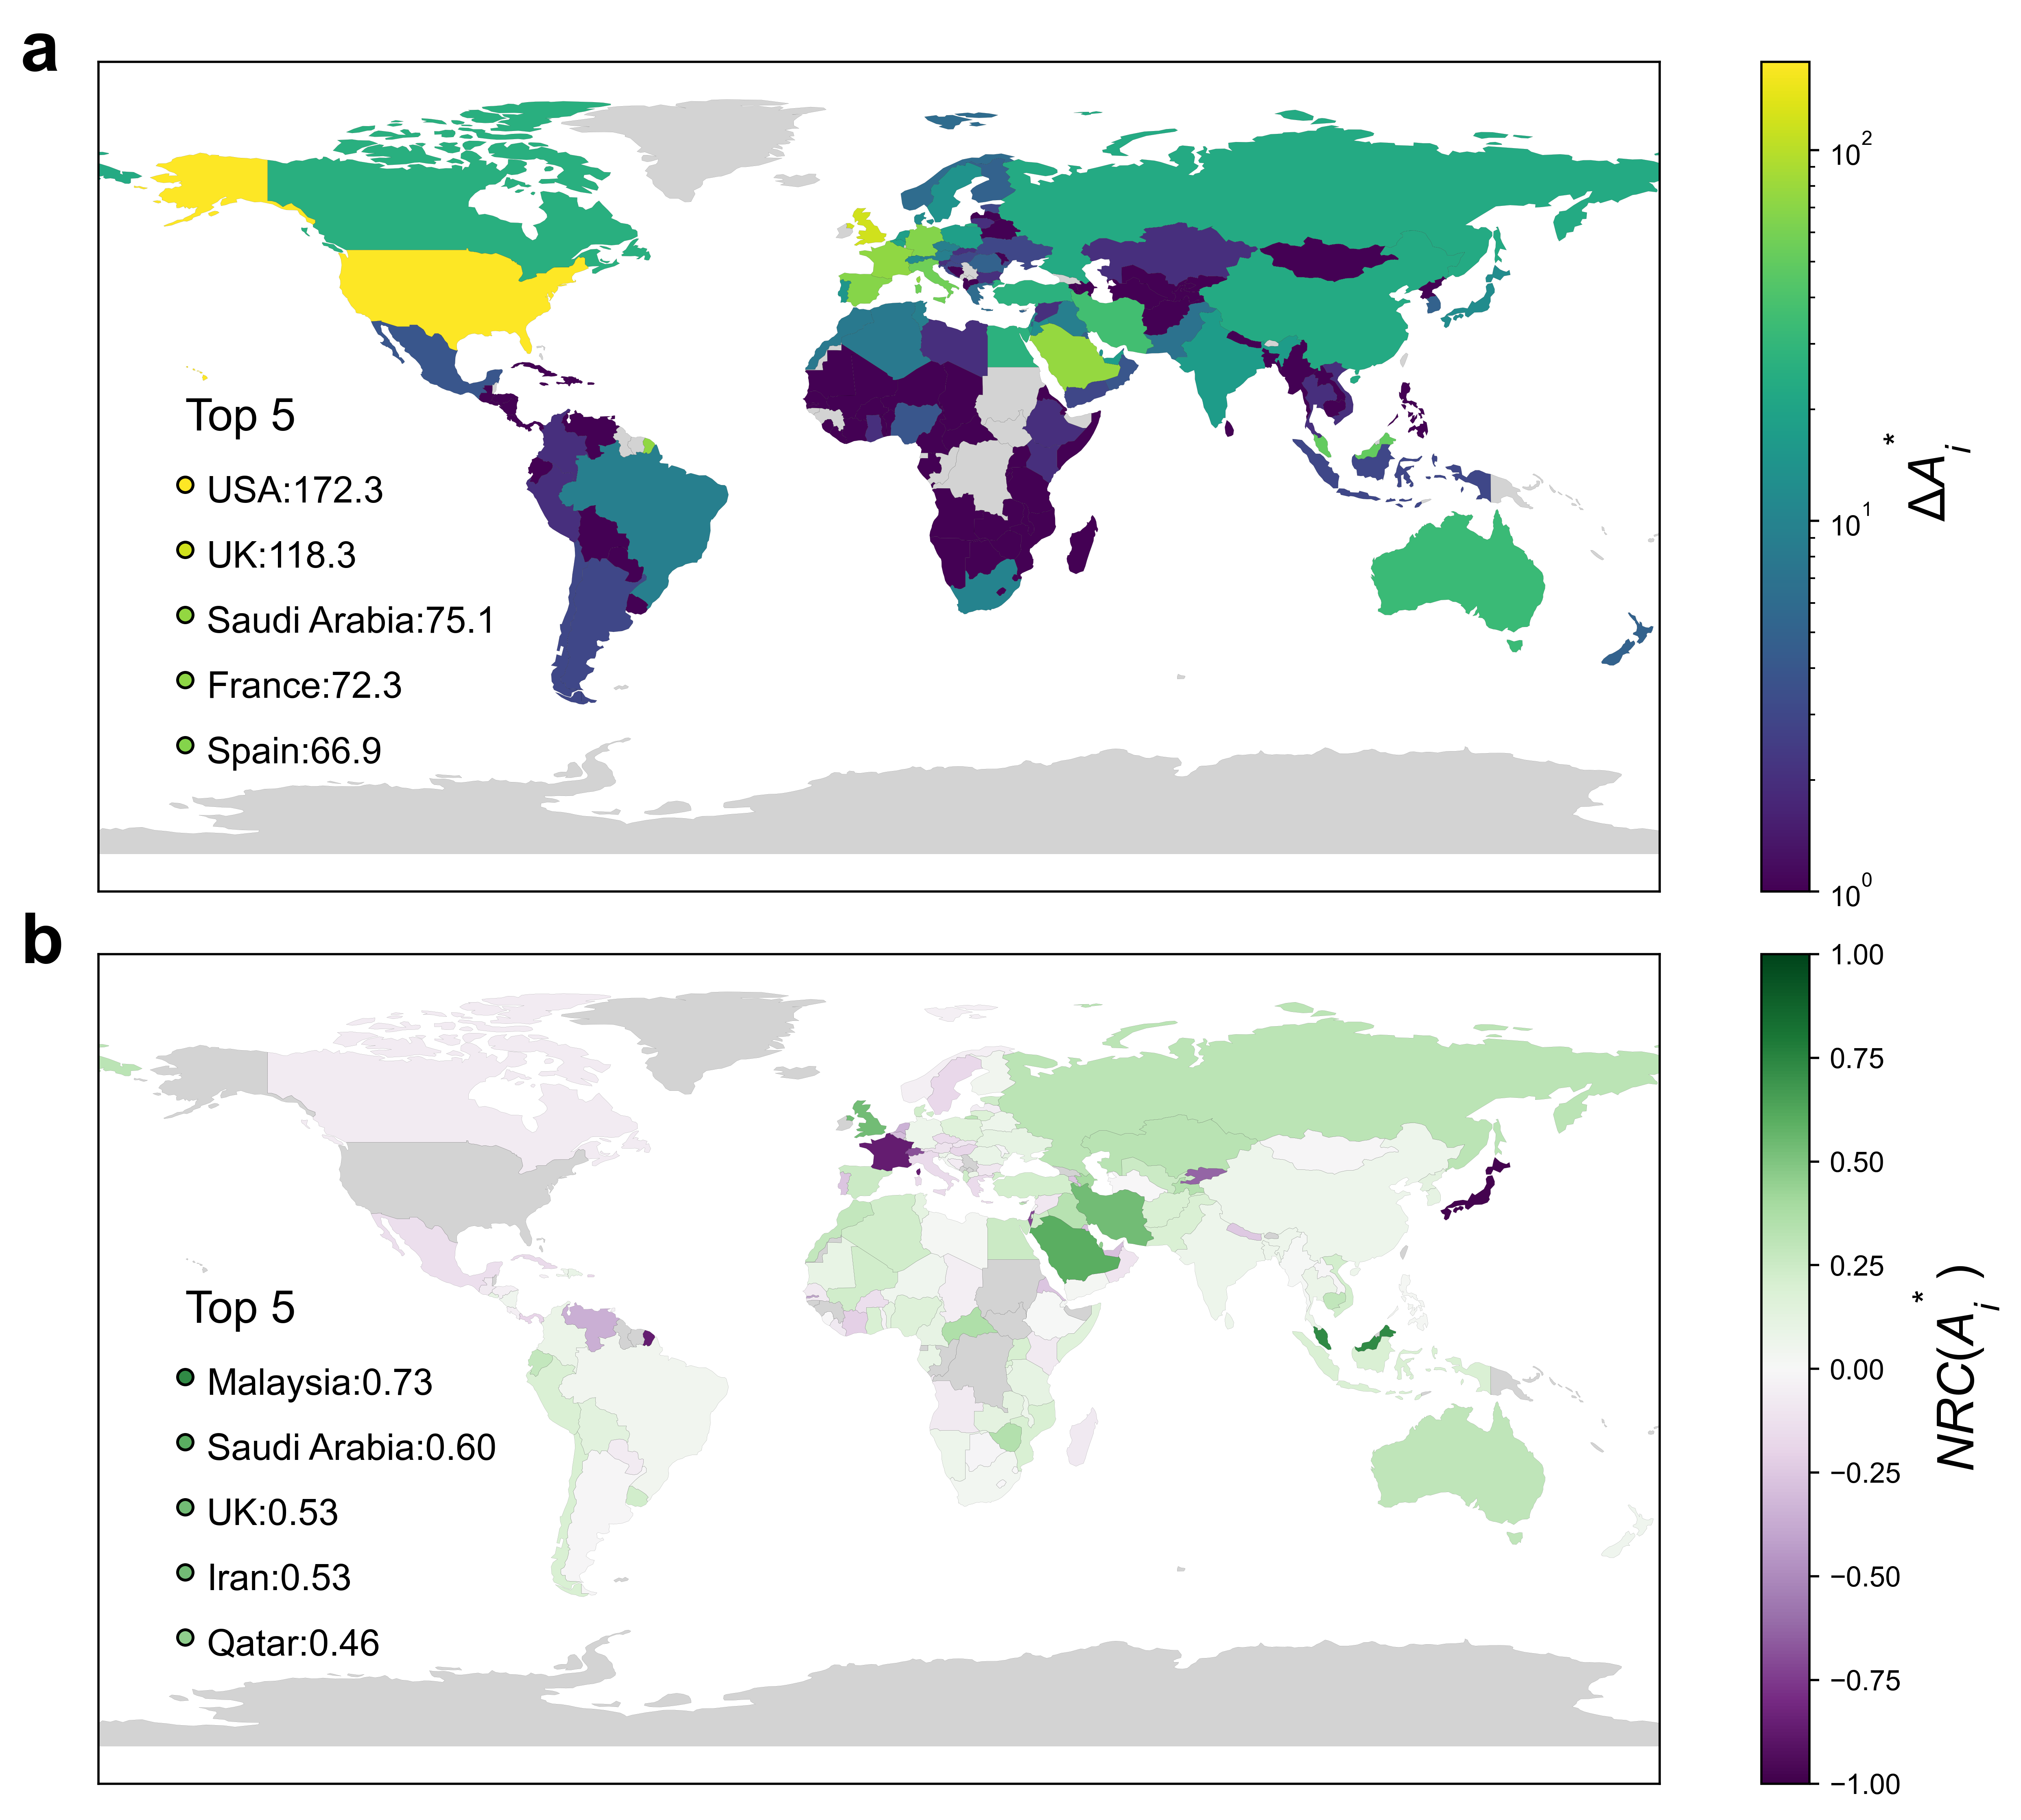

In [4]:
# Create a new figure with custom subplot layout/
start_year, middle_year1,middle_year2, end_year=2002, 2011, 2011, 2020
fig = plt.figure(figsize=(10, 9),dpi=500)

# Create grid specification for subplots
gs = fig.add_gridspec(2, 23)

ax1 = fig.add_subplot(gs[0, 0:22])
subax1=fig.add_subplot(gs[0, 22])
ax1.text(-0.05, 1.05, 'a', transform=ax1.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
ax2 = fig.add_subplot(gs[1, 0:22])
subax2 = fig.add_subplot(gs[1, 22])
ax2.text(-0.05, 1.05, 'b', transform=ax2.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
plotAB(ax1, ax2, subax1, subax2 , start_year, middle_year1,middle_year2, end_year)
ax1.set_xlim(-180, 180)
ax2.set_xlim(-180, 180)

fig.tight_layout()
fig.savefig('Figure5.pdf')
fig.savefig('Figure5.eps')


In [3]:
def plotAB(ax3, ax4, subax3, subax4, start_year, middle_year1,middle_year2, end_year):  
    # -----------------------------------------
    # 1) Read and preprocess main DataFrame
    # -----------------------------------------
    df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")

    # Rename columns in a single step
    df.rename(
        columns={
            'year': 'Year',
            'aggregated_value': 'count',
            'country': 'Mention_country',
            'affiliation_country': 'Aff_country'
        },
        inplace=True
    )

    # Define dictionary for countries and get lowercase abbreviations
    Country_list = {
        'Egypt': 'EGY', 'Tunisia': 'TUN', 'Libya': 'LBY', 'Syria': 'SYR', 'Yemen': 'YEM',
        'Bahrain': 'BHR', 'Jordan': 'JOR', 'Kuwait': 'KWT', 'Morocco': 'MAR', 'Oman': 'OMN'
    }
    abbr = [code.lower() for code in Country_list.values()]

    # Exclude certain subject areas
    physical_sciences = ['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
    df = df[~df['subjarea'].isin(physical_sciences)]

    # Group, sum, and reset index
    df = df.groupby(['Year', 'Mention_country', 'Aff_country'], as_index=False)['count'].sum()

    # -----------------------------------------
    # 2) Read and prepare country-code mapping
    # -----------------------------------------
    country_codes = pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
    # Convert iso3 to lowercase
    country_codes['iso3'] = country_codes['iso3'].str.lower()
    # Build dictionary in one go using set_index + to_dict
    map_dict = country_codes.set_index('iso3')['name'].to_dict()

    # Update manual overrides
    map_dict['irn'] = 'Iran'
    map_dict['usa'] = 'USA'
    map_dict['gbr'] = 'UK'



    def create_period_df(data: pd.DataFrame,
                        year_range: range,
                        abbr_list: list,
                        suffix: str) -> pd.DataFrame:
        """
        Creates a DataFrame for a specific period (e.g. 'before' or 'after'),
        including both total count and 'target' count (mentions of interest).
        """
        # Filter by the given year range
        filtered = data[data['Year'].isin(year_range)]
        
        # Group and sum total counts
        count_df = (
            filtered
            .groupby('Aff_country', as_index=False)['count']
            .sum()
            .rename(columns={'count': f'count_{suffix}'})
        )
        
        # Group and sum 'target' counts (only certain Mention_countries)
        target_df = (
            filtered[
                (filtered['Mention_country'].isin(abbr_list)) &
                (filtered['Mention_country'] != filtered['Aff_country'])
            ]
            .groupby('Aff_country', as_index=False)['count']
            .sum()
            .rename(columns={'count': f'target_count_{suffix}'})
        )
        
        return count_df.merge(target_df, on='Aff_country', how='left')

    # -----------------------------------------
    # 4) Build before_df and after_df
    #    (Assuming start_year, middle_year1, middle_year2, end_year exist)
    # -----------------------------------------
    # Replace np.arange(..., 1) with Python range(...) for cleaner syntax
    before_df = create_period_df(
        data=df,
        year_range=range(start_year, middle_year1),
        abbr_list=abbr,
        suffix='before'
    )

    after_df = create_period_df(
        data=df,
        year_range=range(middle_year2, end_year),
        abbr_list=abbr,
        suffix='after'
    )

    # Merge the two CDF DataFrames
    merged_df = before_df.merge(after_df, on='Aff_country', how='outer')
    merged_df=merged_df[merged_df['Aff_country'].isin(possible_countries)]
    #merged_df=merged_df.fillna(0)
    method='dense'
    na='top'
    merged_df['cdf_after_world']=merged_df['count_after'].rank(method=method, pct=True, na_option=na)
    merged_df['cdf_before_world']=merged_df['count_before'].rank(method=method, pct=True, na_option=na)
    merged_df['cdf_after_target']=merged_df['target_count_after'].rank(method=method, pct=True, na_option=na)
    merged_df['cdf_before_target']=merged_df['target_count_before'].rank(method=method, pct=True, na_option=na)
    merged_df.fillna(0, inplace=True)

    new_df = (
        merged_df
        .assign(
            difference_target=lambda x: x['cdf_after_target'] - x['cdf_before_target'],
            relative_difference=lambda x: (
                (x['difference_target']) / (1 - x['cdf_before_target'])
            ),
            # Normalize target counts by length of each period
            target_count_before=lambda x: x['target_count_before'] / len(range(start_year, middle_year1)),
            target_count_after=lambda x: x['target_count_after'] / len(range(middle_year2, end_year)),
            # difference in average (normalized) target counts
            dif_count=lambda x: x['target_count_after'] - x['target_count_before'],
            # Convert affiliation country code to uppercase
            Aff_country=lambda x: x['Aff_country'].str.upper(),
            # difference in total counts
        )
    )



    # Load the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Assume new_df is a DataFrame with columns 'Aff_country' and 'ratio'
    # Merge your data with the world map
    
    world = world.merge(new_df, left_on='iso_a3', right_on='Aff_country', how='left')


       # Find the top 5 countries by ratio
    top_countries = world.dropna(subset=['dif_count']).nlargest(5, 'dif_count')


    # Plot the map
    world.boundary.plot(ax=ax3, color='k', linewidth=0.02)
    norm = matplotlib.colors.LogNorm()  # Normalization for the colormap

    world['dif_count']=world['dif_count'].round()+1
    cmap = plt.cm.viridis  # Colormap
    world.plot(column='dif_count', ax=ax3, cmap=cmap, norm=norm,
               missing_kwds={'color': 'lightgrey'})
    
    sm_ax3 = ScalarMappable(norm=norm, cmap=cmap)
    sm_ax3.set_array([])  # Necessary to 'activate' the ScalarMappable for the colorbar
    cbarax3=plt.colorbar(sm_ax3, cax=subax3, orientation='vertical')
    cbarax3.set_label(r"$\Delta A^*_i$", size=18)  # Adjust fontsize here


 
    # Coordinates in the ocean to place annotations and points (manually specified)
    ocean_points = [
        (-160, -5),  # Example coordinates, you may need to adjust these
        (-160, -20),
        (-160, -35),
        (-160, -50),
        (-160, -65)
    ]
    ax3.text(-160, 15, 'Top 5',verticalalignment='top', horizontalalignment='left', fontsize=16)
    top_countries.set_index(top_countries.name, inplace=True)
    top_countries.rename(index={'United States of America':'USA', 'United Kingdom':'UK', 'United Arab Emirates':'UAE'}, inplace=True)
 
    # Plot top countries points with annotations in the ocean
    for idx, (point, row) in enumerate(zip(ocean_points, top_countries.iterrows())):
        _, row = row
        if row['name']=='United States of America':
            name='USA'
        elif row['name']=='United Kingdom':
            name='UK'
        else:
            name=row['name']
        color = cmap(norm(row['dif_count']))  # Get the color from the colormap and normalization
        ax3.scatter(point[0], point[1], color=color, edgecolor='black', s=30)  # Plot point
        ax3.text(point[0]+5, point[1]+2, f"{name}:{row['dif_count']:.1f}",
                 verticalalignment='top', horizontalalignment='left', fontsize=13)

    ax3.set_xticks([])
    ax3.set_yticks([])





    # Load the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    new_df['Aff_country'] = new_df['Aff_country'].apply(lambda x: x.upper())
    # Merge your data with the world map
    world = world.merge(new_df, left_on='iso_a3', right_on='Aff_country', how='left')
    print(world.relative_difference.min(),world.relative_difference.max())
    vmin = -1
    vmax = 1
    
    vcenter = 0
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = plt.cm.PRGn   
    # Plot the map
    world.boundary.plot(ax=ax4, color='k', linewidth=0.02)
    world.plot(column='relative_difference', ax=ax4, cmap=cmap, norm=norm,
               missing_kwds={'color': 'lightgrey'})
    sm_ax3 = ScalarMappable(norm=norm, cmap=cmap)
    sm_ax3.set_array([])  # Necessary to 'activate' the ScalarMappable for the colorbar
    cbar_ax3 =plt.colorbar(sm_ax3, cax=subax4, orientation='vertical' )
    cbar_ax3.set_label(r"$NRC (A_i^*)$", size=18)
 
    # Find the top 5 countries by ratio
    top_countries = world.dropna(subset=['relative_difference']).nlargest(5, 'relative_difference')

    # Coordinates in the ocean to place annotations and points (manually specified)

    ax4.text(-160, 15, 'Top 5',verticalalignment='top', horizontalalignment='left', fontsize=16)

    # Plot top countries points with annotations in the ocean
    for idx, (point, row) in enumerate(zip(ocean_points, top_countries.iterrows())):
        _, row = row
        if row['name']=='United States of America':
            name='USA'
        elif row['name']=='United Kingdom':
            name='UK'
        else:
            name=row['name']
        color = cmap(norm(row['relative_difference']))  # Get the color from the colormap and normalization
        ax4.scatter(point[0], point[1], color=color, edgecolor='black', s=30)  # Plot point
        ax4.text(point[0] + 5, point[1] + 2, f"{name}:{row['relative_difference']:.2f}",
                 verticalalignment='top', horizontalalignment='left', fontsize=13)

    ax4.set_xticks([])
    ax4.set_yticks([])